# Statistical Analysis for CAs that Display SSL Interception Behavior

**Getting Dataframe of SSL Interceptors**

In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lit
import os
import sys
import pandas as pd

In [6]:
def union_dfs(base_df: DataFrame, target_df: DataFrame) -> DataFrame:
    base_columns = set(base_df.columns)
    target_columns = set(target_df.columns)
    base_missing = base_columns.difference(target_columns)
    target_missing = target_columns.difference(base_columns)

    new_base = base_df
    new_target = target_df

    for column in base_missing:
        new_base = new_base.withColumn(column, lit(None))
    for column in target_missing:
        new_target = new_target.withColumn(column, lit(None))
    
    return new_base.unionByName(new_target)

In [7]:
def get_dfs(SQLContext: SparkSession, data_path: str) -> DataFrame:
    parquet_files = os.listdir(data_path)
    base_df = SQLContext.read.parquet(data_path + parquet_files[0])
    for parquet_file in parquet_files[1:]:
        try:
            df = SQLContext.read.parquet(data_path + parquet_file)
            base_df = union_dfs(base_df, df)
        except Exception as e:
            print(e)
            print(f"{parquet_file} unable to be read")
    return base_df

In [4]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [9]:
DATA_PATH = "/mnt/chaseproject/uva/kd5eyn/all_ca_data/"
SQLContext = SparkSession.builder.master("local[1]") \
        .appName("session-0") \
        .getOrCreate()
df = get_dfs(SQLContext, DATA_PATH)

Cannot resolve column name "cert_id" among (fingerprint, _lpp_ver, anon_orig, anon_resp, cert_chain_fps, cipher, client_cert_chain_fps, curve, established, id_orig_h, id_orig_p, id_resp_h, id_resp_p, ja3, ja3s, last_alert, next_protocol, resumed, server_name, sni_matches_cert, ssl_history, ts, uid, validation_status, version, anon_san_dns, anon_san_uri, basic_constraints_ca, basic_constraints_path_len, certificate_curve, certificate_exponent, issuer, certificate_key_alg, certificate_key_length, certificate_key_type, certificate_not_valid_after, certificate_not_valid_before, certificate_serial, certificate_sig_alg, certificate_subject, certificate_version, client_cert, host_cert, san_dns, san_email, san_uri, issuer_O, domain);
anon.ssl_20220429_1930-2000-0400.log_ca.parquet unable to be read
Cannot resolve column name "cert_id" among (fingerprint, _lpp_ver, anon_orig, anon_resp, cert_chain_fps, cipher, client_cert_chain_fps, curve, established, id_orig_h, id_orig_p, id_resp_h, id_resp_p

KeyboardInterrupt: 

In [35]:
df.count()

1053873

In [69]:
columns = df.columns
print(columns)

['cert_id', '_lpp_ver', 'anon_orig', 'anon_resp', 'cert_chain_fuids', 'cipher', 'client_cert_chain_fuids', 'client_issuer', 'client_subject', 'curve', 'established', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p', 'issuer', 'ja3', 'ja3s', 'last_alert', 'next_protocol', 'resumed', 'server_name', 'subject', 'ts', 'uid', 'validation_status', 'version', 'anon_san_dns', 'anon_san_ip', 'anon_san_uri', 'basic_constraints_ca', 'basic_constraints_path_len', 'certificate_curve', 'certificate_exponent', 'certificate_issuer', 'certificate_key_alg', 'certificate_key_length', 'certificate_key_type', 'certificate_not_valid_after', 'certificate_not_valid_before', 'certificate_serial', 'certificate_sig_alg', 'certificate_subject', 'certificate_version', 'san_dns', 'san_email', 'san_ip', 'san_uri', 'issuer_O', 'domain']


In [65]:
test_df = SQLContext.read.parquet("/mnt/chaseproject/uva/kd5eyn/ssl/2022-04-23/anon.ssl_20220423_0000-0030-0400.log.gz/")
test_x509_df = SQLContext.read.parquet("/mnt/chaseproject/uva/kd5eyn/x509/2022-04-23/anon.x509_20220423_0000-0030-0400.log.gz/")
new_columns = test_df.columns
new_colums = new_columns.extend(test_x509_df.columns)
print(new_columns)

['_lpp_ver', 'anon_orig', 'anon_resp', 'cert_chain_fps', 'cipher', 'client_cert_chain_fps', 'curve', 'established', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p', 'ja3', 'ja3s', 'last_alert', 'next_protocol', 'resumed', 'server_name', 'sni_matches_cert', 'ssl_history', 'ts', 'uid', 'validation_status', 'version', '_lpp_ver', 'anon_san_dns', 'anon_san_ip', 'anon_san_uri', 'basic_constraints_ca', 'basic_constraints_path_len', 'certificate_curve', 'certificate_exponent', 'certificate_issuer', 'certificate_key_alg', 'certificate_key_length', 'certificate_key_type', 'certificate_not_valid_after', 'certificate_not_valid_before', 'certificate_serial', 'certificate_sig_alg', 'certificate_subject', 'certificate_version', 'client_cert', 'fingerprint', 'host_cert', 'san_dns', 'san_email', 'san_ip', 'san_uri', 'ts']


In [67]:
set(new_columns) - set(columns)

{'cert_chain_fps',
 'client_cert',
 'client_cert_chain_fps',
 'fingerprint',
 'host_cert',
 'sni_matches_cert',
 'ssl_history'}

**Filtering out SSL Interceptors**

In [6]:
def get_interceptor_rows(df: DataFrame, blacklist_path: str) -> DataFrame:
    with open(blacklist_path, "r") as blacklist_file:
        blacklist = blacklist_file.read().splitlines()
    df_interceptors = df.filter(df.issuer_O.isin(blacklist))
    return df_interceptors

In [7]:
BLACKLIST_PATH = "/home/ubuntu/GitLab/ssl_interception/lists/blacklist.txt"
df_intercept = get_interceptor_rows(df, BLACKLIST_PATH)

In [8]:
df_intercept.select("issuer_O").distinct().collect()

[Row(issuer_O='EMR Direct'),
 Row(issuer_O='FIREEYE'),
 Row(issuer_O='Cisc'),
 Row(issuer_O='Polycom'),
 Row(issuer_O='Private Internet Access'),
 Row(issuer_O='McAfee'),
 Row(issuer_O='Kaspersky'),
 Row(issuer_O='McAfe'),
 Row(issuer_O='MaxMD'),
 Row(issuer_O='Kaspersky Lab'),
 Row(issuer_O='Fortinet')]

**Validity Period Analysis**

In [9]:
from analysis_helpers.intercept_helpers import get_num_days, get_cert_validity
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType, BooleanType
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
get_num_days_udf = udf(lambda not_before_str, not_after_str: get_num_days(not_before_str, not_after_str), IntegerType())
get_cert_validity_udf = udf(lambda timestamp, not_before_str, not_after_str: get_cert_validity(timestamp, not_before_str, not_after_str), BooleanType())
df_intercept = df_intercept.withColumn("num_days_valid", get_num_days_udf(col("certificate_not_valid_before"), col("certificate_not_valid_after")))
df_intercept = df_intercept.withColumn("valid_at_ts", get_cert_validity_udf(col("ts"), col("certificate_not_valid_before"), col("certificate_not_valid_after")))

In [11]:
df_intercept_pd = df_intercept.toPandas()

In [12]:
certificate_validity = df_intercept_pd.groupby("certificate_serial", as_index=False).agg({"num_days_valid": "mean"})

In [13]:
df_intercept_pd[df_intercept_pd["num_days_valid"] > 1000].drop_duplicates("certificate_serial")

,cert_id,_lpp_ver,anon_orig,anon_resp,cert_chain_fuids,cipher,client_cert_chain_fuids,client_issuer,client_subject,curve,...,certificate_subject,certificate_version,san_dns,san_email,san_ip,san_uri,issuer_O,domain,num_days_valid,valid_at_ts
5,F4yuDEbiQquKMECpf,1.11-7,uva,none,"[F4yuDEbiQquKMECpf, FklfoQ1Ah5llXAenq3]",TLS_RSA_WITH_AES_256_GCM_SHA384,"[FHJnqP3YSJnijwsV21, F7Otka1F6ipEfQM2b2]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...","emailAddress=42k6Qjzw@fortinet.com,CN=M7WR1Apz...",None,...,"emailAddress=42k6Qjzw@fortinet.com,CN=M7WR1Apz...",3,None,None,None,None,Fortinet,None,7577,True
1710,FLLNHG1DZpjJVugF62,1.11-7,uva,none,[FLLNHG1DZpjJVugF62],TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,[Fxvrln2OMkL58CrA5b],"CN=55Rxr1t8Ib2,OU=PRODUCT,O=FIREEYE,L=RESTON,S...","CN=7CSQ81qaSb7,O=FIREEYE,ST=VA,C=US",secp256r1,...,"CN=1585966872982-908-sfs.crt.uid,OU=PRODUCT,O=...",3,None,None,None,None,FIREEYE,sfServer.hexjkb678-hx-agent-1.hex01.helix.apps...,1826,True
5926,FKNN3F3bbM6jWgkDE8,1.11-7,uva,none,[FKNN3F3bbM6jWgkDE8],TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,[],None,None,secp256r1,...,"CN=5o_6dQHRE5FUO1iKcG,OU=ePO,O=McAfee",3,None,None,None,None,McAfe,1MaKV7iJ.,27911,True
7856,FnpzZm2E8ZHqpcXFQi,1.11-7,uva,none,"[FnpzZm2E8ZHqpcXFQi, F4tnUqVUxoFtEMai5]",TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,[],None,None,secp521r1,...,"CN=customerusagedatacollection.polycom.com,OU=...",3,"[customerusagedatacollection.polycom.com, 52.4...",None,None,None,Polycom,None,7304,True


<AxesSubplot:xlabel='num_days_valid', ylabel='Count'>

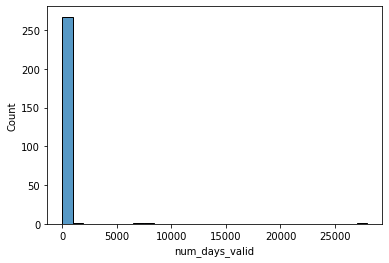

In [14]:
sns.histplot(data=certificate_validity, x="num_days_valid", bins=30)

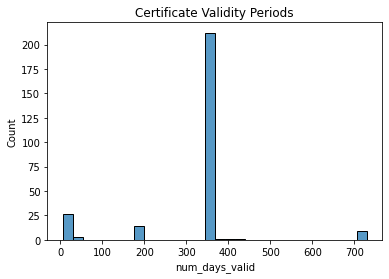

In [15]:
certificate_validity_no_outliers = certificate_validity[certificate_validity["num_days_valid"] < 1000]
sns.histplot(data=certificate_validity_no_outliers, x="num_days_valid", bins=30)
plt.title("Certificate Validity Periods")
plt.show()

In [16]:
df_intercept_pd[df_intercept_pd["num_days_valid"] > 397].drop_duplicates("certificate_serial").shape[0]

15

In [17]:
valid_at_ts_df = df_intercept_pd.groupby("certificate_serial", as_index=False).agg({"valid_at_ts": "all"})

In [18]:
percentages = valid_at_ts_df["valid_at_ts"].value_counts(normalize=True)*100
percentages

True    100.0
Name: valid_at_ts, dtype: float64

In [19]:
df_intercept_pd[df_intercept_pd["valid_at_ts"] != True]

,cert_id,_lpp_ver,anon_orig,anon_resp,cert_chain_fuids,cipher,client_cert_chain_fuids,client_issuer,client_subject,curve,...,certificate_subject,certificate_version,san_dns,san_email,san_ip,san_uri,issuer_O,domain,num_days_valid,valid_at_ts


# Cipher Suites

In [20]:
import requests
from typing import Dict, List
from json import loads

In [21]:
df_intercept_pd["cipher"].unique()

array(['TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384',
       'TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256',
       'TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384',
       'TLS_RSA_WITH_AES_256_GCM_SHA384',
       'TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA384',
       'TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256',
       'TLS_DHE_RSA_WITH_AES_256_GCM_SHA384',
       'TLS_RSA_WITH_AES_256_CBC_SHA', 'TLS_DHE_RSA_WITH_AES_256_CBC_SHA',
       'TLS_RSA_WITH_AES_128_CBC_SHA',
       'TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA',
       'TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA',
       'TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA256'], dtype=object)

In [22]:
cert_cipher_df = df_intercept_pd[["certificate_serial", "cipher"]].copy(deep=True)
cert_cipher_df.drop_duplicates(inplace=True)

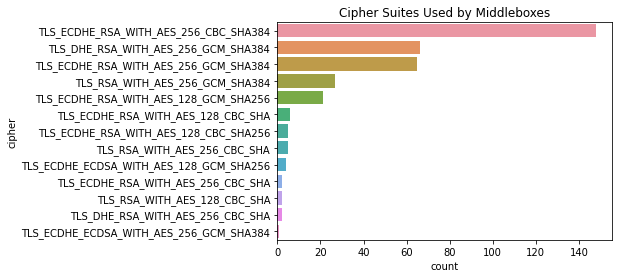

In [23]:
sns.countplot(y=cert_cipher_df["cipher"], order=cert_cipher_df["cipher"].value_counts().index)
plt.title("Cipher Suites Used by Middleboxes")
plt.show()

In [24]:
def get_cipher_suite_info(cipher_suites: List[str]) -> Dict[str, Dict]:
    cipher_suite_info = {}
    for cipher_suite in cipher_suites:
        url = f"https://ciphersuite.info/api/cs/{cipher_suite}"
        cipher_suite_info[cipher_suite] = loads(requests.get(url).content)[cipher_suite]
    return cipher_suite_info
        

In [25]:
ciphers_used = df_intercept_pd["cipher"].unique()
cipher_info = get_cipher_suite_info(ciphers_used)

In [26]:
cipher_info["TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA384"]

{'gnutls_name': 'TLS_ECDHE_RSA_AES_256_CBC_SHA384',
 'openssl_name': 'ECDHE-RSA-AES256-SHA384',
 'hex_byte_1': '0xC0',
 'hex_byte_2': '0x28',
 'protocol_version': 'TLS',
 'kex_algorithm': 'ECDHE',
 'auth_algorithm': 'RSA',
 'enc_algorithm': 'AES 256 CBC',
 'hash_algorithm': 'SHA384',
 'security': 'weak',
 'tls_version': ['TLS1.2']}

In [27]:
def get_cipher_attr(cipher: str, cipher_info: Dict[str, Dict], key: str) -> str:
    return cipher_info[cipher][key]

In [28]:
cert_cipher_df["cipher_security_level"] = cert_cipher_df.apply(lambda row: get_cipher_attr(row["cipher"], cipher_info, "security"), axis=1)

Text(0.5, 1.0, 'Cipher Suite Security Levels')

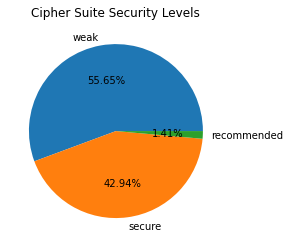

In [29]:
percentages = cert_cipher_df["cipher_security_level"].value_counts(normalize=True)*100
plt.pie(percentages, labels=percentages.index, autopct="%1.2f%%")
plt.title("Cipher Suite Security Levels")

# TLS Versions

In [30]:
df_intercept_pd.columns

Index(['cert_id', '_lpp_ver', 'anon_orig', 'anon_resp', 'cert_chain_fuids',
       'cipher', 'client_cert_chain_fuids', 'client_issuer', 'client_subject',
       'curve', 'established', 'id_orig_h', 'id_orig_p', 'id_resp_h',
       'id_resp_p', 'issuer', 'ja3', 'ja3s', 'last_alert', 'next_protocol',
       'resumed', 'server_name', 'subject', 'ts', 'uid', 'validation_status',
       'version', 'anon_san_dns', 'anon_san_ip', 'anon_san_uri',
       'basic_constraints_ca', 'basic_constraints_path_len',
       'certificate_curve', 'certificate_exponent', 'certificate_issuer',
       'certificate_key_alg', 'certificate_key_length', 'certificate_key_type',
       'certificate_not_valid_after', 'certificate_not_valid_before',
       'certificate_serial', 'certificate_sig_alg', 'certificate_subject',
       'certificate_version', 'san_dns', 'san_email', 'san_ip', 'san_uri',
       'issuer_O', 'domain', 'num_days_valid', 'valid_at_ts'],
      dtype='object')

In [31]:
tls_version_df = df_intercept_pd[["certificate_serial", "version"]].copy(deep=True)
tls_version_df.drop_duplicates(inplace=True)

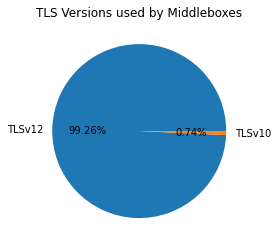

In [32]:
percentages = tls_version_df["version"].value_counts(normalize=True)*100
plt.pie(percentages, labels=percentages.index, autopct="%1.2f%%")
plt.title("TLS Versions used by Middleboxes")
plt.show()

In [33]:
tls_version_df[tls_version_df["version"] == "TLSv10"]
tls_old_df = pd.merge(tls_version_df[tls_version_df["version"] == "TLSv10"], df_intercept_pd)
tls_old_df

,certificate_serial,version,cert_id,_lpp_ver,anon_orig,anon_resp,cert_chain_fuids,cipher,client_cert_chain_fuids,client_issuer,...,certificate_subject,certificate_version,san_dns,san_email,san_ip,san_uri,issuer_O,domain,num_days_valid,valid_at_ts
0,8144EC,TLSv10,Fl4whZ23QmS804CK65,1.11-7,uva,none,"[Fl4whZ23QmS804CK65, FAxJWnv476WNRU7ib]",TLS_RSA_WITH_AES_256_CBC_SHA,"[FydNkn4L0Eh9yvYE9k, F5KeiI2gfOJhxDDUA4]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True
1,8144EC,TLSv10,F7zIO83KIbtzK3uFE5,1.11-7,uva,none,"[F7zIO83KIbtzK3uFE5, FJioD43pZlHugFQnGf]",TLS_RSA_WITH_AES_256_CBC_SHA,"[FiJeDw37ILLHgMHzu3, Fxm6rX3N2xY6mJqrWe]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True
2,8144EC,TLSv10,FhUcYc3nHITFBh1OA4,1.11-7,uva,none,"[FhUcYc3nHITFBh1OA4, F8bFdD2AJ9xq5qAj04]",TLS_RSA_WITH_AES_256_CBC_SHA,"[FZ4f794KWjkT5sOBOc, FTjZup34VcGAkWTwh]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True
3,8144EC,TLSv10,FL9fOw2lNuLnjbcKgk,1.11-7,uva,none,"[FL9fOw2lNuLnjbcKgk, FGsNyx3mZKdmMXrgid]",TLS_RSA_WITH_AES_256_CBC_SHA,"[Fnvzgy4DOSV89DtJI, FOiAOy4nCdDQQ7e1Q1]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True
4,8144EC,TLSv10,FuOTju4qL0VRSmZYxf,1.11-7,uva,none,"[FuOTju4qL0VRSmZYxf, FIjdDU3NkMd0wjy7Vb]",TLS_RSA_WITH_AES_256_CBC_SHA,"[FoGSNg81jQVLzklig, FuqbZs2fmU8eT2Ie7f]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True
5,8144EC,TLSv10,Fo0Une3v5KKYqUYerl,1.11-7,uva,none,"[Fo0Une3v5KKYqUYerl, FFlkMTdLgmy0lsmCe]",TLS_RSA_WITH_AES_256_CBC_SHA,"[FEWT3R3WwlVyTc9Kud, FUXHzb4Hg24HaWABc6]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True
6,8144EC,TLSv10,Fia7GfWGphcZl1yF9,1.11-7,uva,none,"[Fia7GfWGphcZl1yF9, F5R1bI1wD7E1ntkaN3]",TLS_RSA_WITH_AES_256_CBC_SHA,"[F601v64ki50joA9D, FYnRHX3uVdOuTaYaGe]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True
7,8144EC,TLSv10,FLVJ8jDsJLp0miJh,1.11-7,uva,none,"[FLVJ8jDsJLp0miJh, Fv22St4q4uhJQKhpn3]",TLS_RSA_WITH_AES_256_CBC_SHA,"[Fo6Uwf4g1OJuJqf2q, F4GUHf4vVBVqruAPGa]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True
8,8144EC,TLSv10,Ff5TPn4rg1qIfUi2M1,1.11-7,uva,none,"[Ff5TPn4rg1qIfUi2M1, FJG1tN1nHJ3bNp0545]",TLS_RSA_WITH_AES_256_CBC_SHA,"[FF1K5n4fSKRJzwmnQ9, FyqDk6Awurxylbj05]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True
9,8144EC,TLSv10,FFXBGc3CaB1iZVyGge,1.11-7,uva,none,"[FFXBGc3CaB1iZVyGge, FnbKHW1IDXcpocvcEh]",TLS_RSA_WITH_AES_256_CBC_SHA,"[FSMNaG1k6Hv65VzgTc, F01VASsce6pTc1OY6]","emailAddress=42k6Qjzw@fortinet.com,CN=42k6Qjz,...",...,"emailAddress=42k6Qjzw@fortinet.com,CN=guard.fo...",3,None,None,None,None,Fortinet,None,179,True


In [34]:
tls_old_df["issuer_O"].unique()

array(['Fortinet'], dtype=object)